In [1]:
!pip install pycocotools

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-et0wya5l
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-et0wya5l
  Created wheel for tensorflow-examples: filename=tensorflow_examples-228643b2062756ce2c156e295adfff5b530a0ae5_-cp37-none-any.whl size=243231 sha256=c66dba2a5424ec8f3f5f8d5c4694c84052bdbeafd8e5e78c47793407158004fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-d10lkvdf/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [3]:
#!pip install pydot
#!pip install pydotplus
#!pip install graphviz

In [4]:
!pip install imantics

  Created wheel for imantics: filename=imantics-0.1.12-cp37-none-any.whl size=16033 sha256=89ae2866d62739a18e30c06e48f3d1ac7ca9db690eae5b6de95bf5a30ff57e42
  Stored in directory: /root/.cache/pip/wheels/73/93/1c/9e2fc52eb74441941bc76cac441ddcc2c7ad67b18e1849e62a
Successfully built imantics


In [5]:
from pycocotools.coco import COCO
import numpy as np

import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pydot
from imantics import Polygons, Mask
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import time

## For visualizing results

import matplotlib.gridspec as gridspec
import sys
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/code

Mounted at /content/gdrive
/content/gdrive/My Drive/code


In [7]:
%cd photovoltaic_images


/content/gdrive/My Drive/code/photovoltaic_images


In [8]:
from utils import *
from models.model import *

In [9]:
# Parameter
x = 192
y = 192

batch_size = 1
input_image_size = (x,y)
OUTPUT_CHANNELS = 1

folder = 'data/Rathausen_192x192'
mode_train = 'train'

mode_val = 'val'
mode_test = 'test'

EPOCHS = 1
STEPS_PER_EPOCH = 250
#VAL_SUBSPLITS = 5
VALIDATION_STEPS = 4

In [10]:
model = mobile_net_v2([192,192,3])

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
images_train, dataset_size_train, coco = filterDataset(folder,  mode_train)
#coco_train = copy.deepcopy(coco)
coco_train = coco

images_val, dataset_size_val, coco = filterDataset(folder,  mode_val)
#coco_val = copy.deepcopy(coco)
coco_val = coco

images_test, dataset_size_test, coco = filterDataset(folder,  mode_test)
#coco_val = copy.deepcopy(coco)
coco_test = coco

loading annotations into memory...
Done (t=2.52s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [12]:
gen_train = dataGeneratorCoco(images_train, coco_train, folder,
                            input_image_size, batch_size, mode_train)
#gen1 = dataGeneratorCoco(images, classes, coco, folder,
#                            input_image_size, 1, 'test', mask_type)
gen_val = dataGeneratorCoco(images_val, coco_val, folder,
                            input_image_size, batch_size, mode_val)
gen_test = dataGeneratorCoco(images_test, coco_test, folder,
                            input_image_size, batch_size, mode_test)

In [13]:
type(gen_train)

generator

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 
                       tf.keras.metrics.MeanIoU(num_classes=2), 
                       tf.keras.metrics.Recall(), 
                       tf.keras.metrics.Precision()])

In [15]:
def show_predictions(model, dataset=None, num=4):
    """[summary]

    Args:
        dataset ([type], optional): [description]. Defaults to None.
        num (int, optional): [description]. Defaults to 4.
    """
    if dataset:
        for i in range(0, num):
            image, mask = next(dataset)
            pred_mask = model.predict(image)
            display([image[0], mask[0], pred_mask[0]])
    else:
        img = model.predict(sample_image)
        display([sample_image[0], sample_mask[0],
             img[0]])

In [16]:
class DisplayCallback(tf.keras.callbacks.Callback):
    """[summary]

    Args:
        tf ([type]): [description]
    """
    def on_epoch_end(self, epoch, logs=True):
        """[summary]

        Args:
            epoch ([type]): [description]
            logs (bool, optional): [description]. Defaults to True.
        """
        clear_output(wait=False)
        show_predictions(model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))  

In [17]:
img, mask = next(gen_val)
sample_image = img
sample_mask = mask

In [18]:
img = model.predict(sample_image)

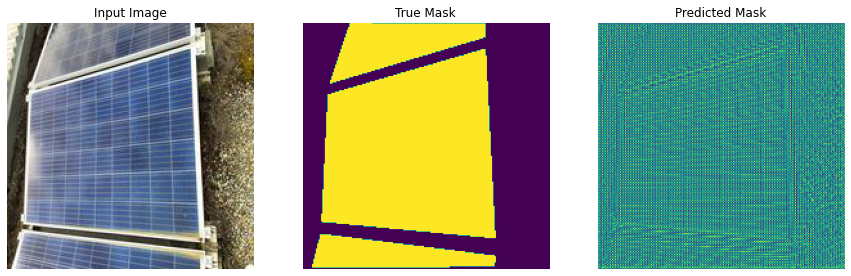

In [19]:
show_predictions(model)

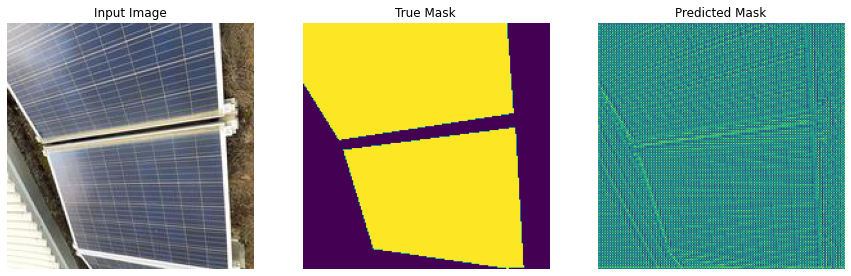

In [20]:
show_predictions(model, gen_train, 1)

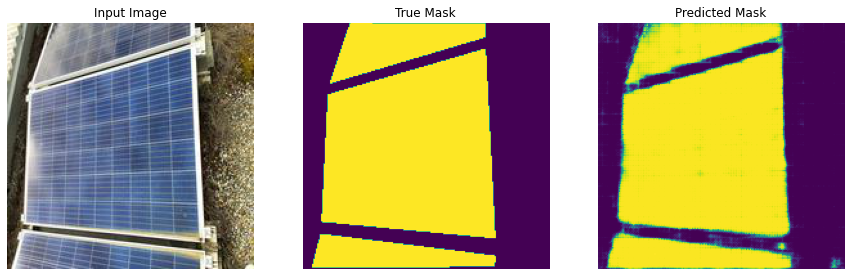


Sample Prediction after epoch 1

--- 80.25454664230347 seconds ---


In [21]:
training_start_time = time.time()
model_history = model.fit(gen_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=gen_val,
                          callbacks=[DisplayCallback()]
                         )
training_time = time.time() - training_start_time
print("--- %s seconds ---" % (time.time() - training_start_time))

In [22]:
model_history.history.keys()


dict_keys(['loss', 'accuracy', 'mean_io_u', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_mean_io_u', 'val_recall', 'val_precision'])

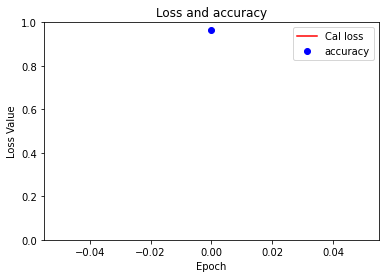

In [23]:
loss = model_history.history['val_loss']
accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Cal loss')
plt.plot(epochs, accuracy, 'bo', label='accuracy')
plt.title('Loss and accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [24]:
model_history.history['val_accuracy'][-1:]

[0.9652167558670044]

In [25]:
#model_history.history['val_accuracy']

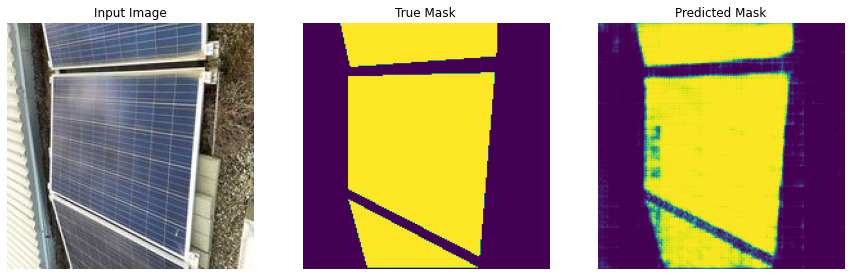

In [26]:
show_predictions(model, gen_train, 1)

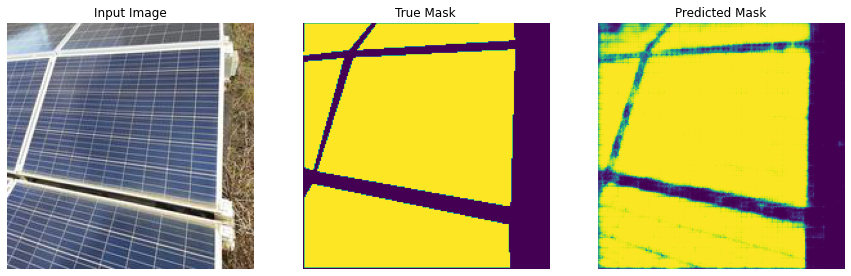

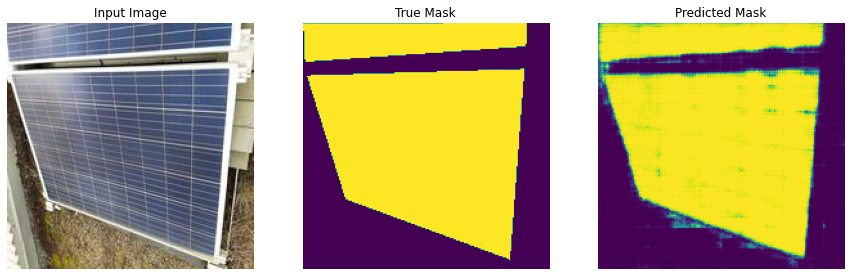

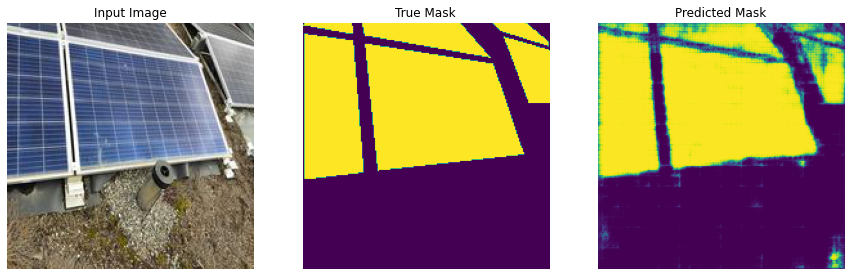

In [27]:
show_predictions(model, gen_val, 3)

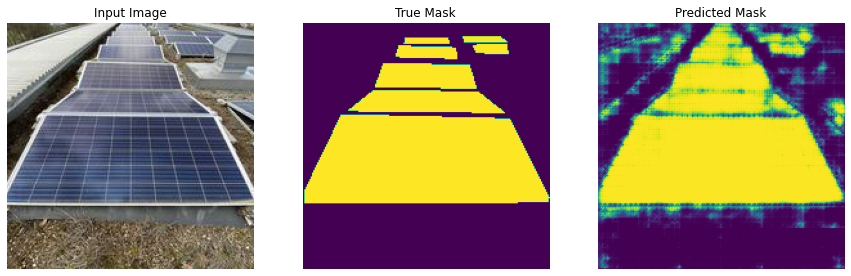

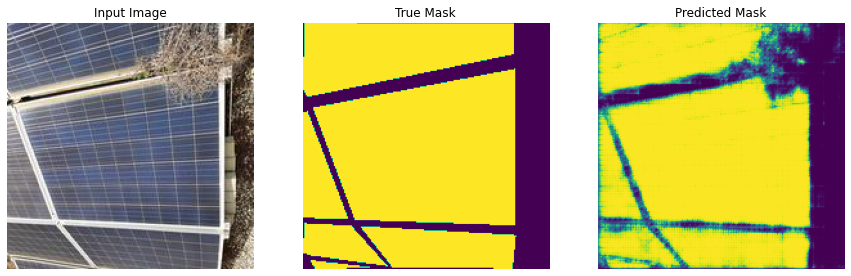

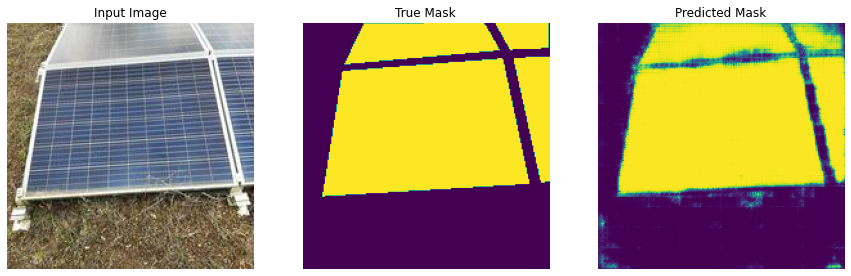

In [28]:
show_predictions(model, gen_test, 3)

In [29]:
from keras.preprocessing.image import save_img

# Store all pictures

In [30]:
import pathlib


In [31]:
images_test[0]['file_name'].split('/')[2]

'IMG_8088.JPEG'

In [32]:
folder_out = 'data/{}/Rathausen_192x192'.format("test")

In [33]:
folder_out_mask = 'data/{}/Rathausen_192x192_mask'.format("test")

In [34]:
pathlib.Path(folder_out).mkdir(parents=True, exist_ok=True) 
pathlib.Path(folder_out_mask).mkdir(parents=True, exist_ok=True)

In [35]:
img = np.zeros((1, x, y, 3)).astype('float')
for i in range(0,33):
    filename = images_test[i]['file_name'].split('/')[2]
    outfile = folder_out + "/" + filename
    outfile_mask = folder_out_mask + "/" + filename
    image = getImage(images_test[i], folder, input_image_size)
    img[0] = image
    
    pred_mask = model.predict(img)
    
    save_img(outfile, image)
    save_img(outfile_mask, pred_mask[0])    

## Evaluate

In [36]:
def calc_predictions(dataset=None, num=2):
    dice = []
    jaccard = []
    if dataset:
        for i in range(0, num):
            image, mask = next(dataset)
            pred_mask = model.predict(image)
            dice.append(dice_coef(sample_mask[0], pred_mask[0]))
            jaccard.append(jaccard_distance(sample_mask[0], pred_mask[0]))
            #display([image[0], mask[0], pred_mask[0]])
    print("Dice", np.mean(dice))
    print("Jaccard", np.mean(jaccard))
    
    return dice, jaccard

In [37]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

In [38]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [39]:
val_dice, val_jaccard = calc_predictions(gen_val, 50)

Dice 0.725108
Jaccard 24.697528423517056


In [40]:
test_dice, test_jaccard = calc_predictions(gen_test, 33)

Dice 0.75483733
Jaccard 23.790789798957814


In [42]:
test_loss, test_accuracy, test_ = model.evaluate(gen_test, batch_size=batch_size, steps=33)

33/33 [==============================] - 0s 13ms/step - loss: 0.0880 - accuracy: 0.9662 - mean_io_u: 0.1871 - recall: 0.9819 - precision: 0.9647


ValueError: ignored

In [ ]:
# Print Model Summary:
print("MODEL SUMMARY")
print("-------------")
print("Training Accuracy:", model_history.history['accuracy'][-1:][0])
print("Validation Accuracy:", model_history.history['val_accuracy'][-1:][0])
print("Test Accuracy:", test_accuracy)
print("-------------")
print("Training Loss:", model_history.history['loss'][-1:][0])
print("Validation Loss:", model_history.history['val_loss'][-1:][0])
#print("Training mean_io_u:", model_history.history['mean_io_u'][-1:][0])
#print("Validation mean_io_u:", model_history.history['mean_io_u'][-1:][0])
print("-------------")
print("Validation Dice:", np.mean(val_dice))
print("Validation Jaccard:", np.mean(val_jaccard))
print("Test Dice:", np.mean(test_dice))
print("Test Jaccard:", np.mean(test_jaccard))

